In [1]:
# 激活函数
%matplotlib inline
import math
import numpy as np
import torch
from IPython import display
from d2l import torch as d2l

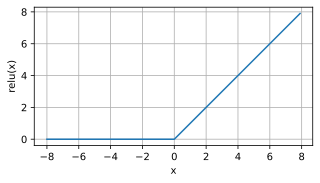

In [2]:
# ReLU函数
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

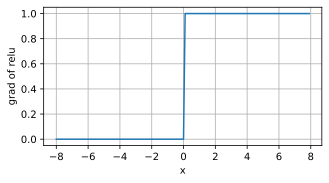

In [3]:
# 求导
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

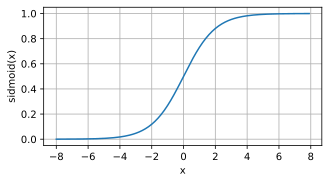

In [4]:
# sigmoid激活函数
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sidmoid(x)', figsize=(5, 2.5))

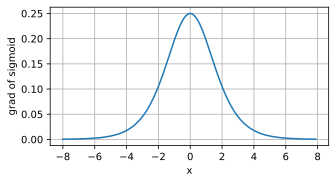

In [5]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

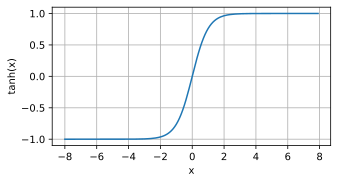

In [6]:
# tanh函数
# 当输入在0附近时，tanh函数接近线性变换。
# 函数的形状类似于sigmoid函数， 不同的是tanh函数关于坐标系原点中心对称。
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

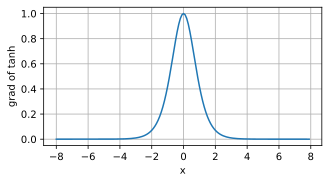

In [7]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [9]:
# 将每个图像视为具有784个输入特征 和10个类的简单分类数据集
# 选择2的若干次幂作为层的宽度，符合内存在硬件中的分配和寻址方式
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [10]:
# ReLU激活函数
def relu(X):
    """ ReLU激活函数 """
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [11]:
# 模型，忽略空间结构
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)
    H1 = H @ W2 + b2
    return H1

In [12]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [13]:
# 分类精度：正确预测数量与总预测数量之比
def accuracy(y_hat, y):  #@save
    """ 计算预测正确的数量 """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 输出的是flatten后的索引
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())

In [14]:
class Accumulator:  #@save
    """ 在n个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
def evaluate_accuracy(net, data_iter):  #@save
    """ 计算在指定数据集模型上的精度 """
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [16]:
class Animator:  #@save
    """ 在动画中绘制数据 """
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """ 训练模型迭代一个周期 """
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和，训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        # print(f"y_hat: {y_hat}")
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用内置的优化器
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


In [18]:
def train_ch3(net, train_iter, test_iter, loss, num_epoch, updater): #@save
    """ 训练模型 """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])   
    for epoch in range(num_epochs):
        train_metric = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metric + (test_acc,))
    train_loss, train_acc = train_metric

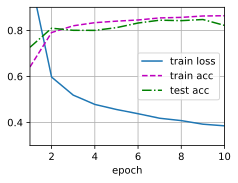

In [19]:
num_epochs, lr = 10, 0.1
# 优化器
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [20]:
# 使用pytorch进行简洁实现
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

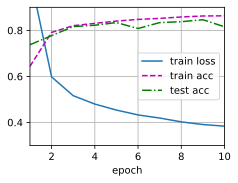

In [21]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [22]:
#  生成数据集
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集的大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [23]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.7989],
         [-0.1447]]),
 tensor([[ 1.0000e+00,  7.9886e-01,  3.1909e-01,  8.4969e-02,  1.6970e-02,
           2.7113e-03,  3.6099e-04,  4.1197e-05,  4.1138e-06,  3.6515e-07,
           2.9171e-08,  2.1185e-09,  1.4103e-10,  8.6665e-12,  4.9452e-13,
           2.6337e-14,  1.3150e-15,  6.1793e-17,  2.7424e-18,  1.1531e-19],
         [ 1.0000e+00, -1.4466e-01,  1.0463e-02, -5.0456e-04,  1.8247e-05,
          -5.2794e-07,  1.2729e-08, -2.6305e-10,  4.7567e-12, -7.6457e-14,
           1.1060e-15, -1.4546e-17,  1.7535e-19, -1.9513e-21,  2.0162e-23,
          -1.9445e-25,  1.7581e-27, -1.4960e-29,  1.2023e-31, -9.1542e-34]]),
 tensor([5.4180, 4.7309]))

In [24]:
# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):
    """ 评估给定数据集上模型的损失 """
    metric = d2l.Accumulator(2)  # 损失的总和，样本数
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [25]:
def train(train_features, test_features, 
          train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction="none")
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])   
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.005854   1.2029693 -3.3680098  5.534777 ]]


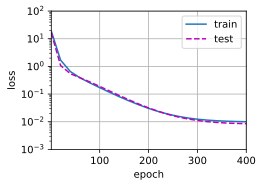

In [26]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4619396 3.4047012]]


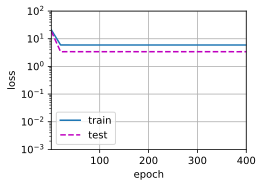

In [27]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9907389e+00  1.2161826e+00 -3.2806585e+00  5.3011775e+00
  -2.8706300e-01  1.1321101e+00  1.6145498e-01  2.4184605e-01
  -2.2354547e-02  2.3009561e-01  4.8721484e-03 -6.4039126e-02
  -9.0697475e-02 -1.8817092e-01  1.4105381e-01 -8.2547724e-02
   1.3137385e-01 -1.1194299e-01 -1.3086611e-01  2.3057744e-02]]


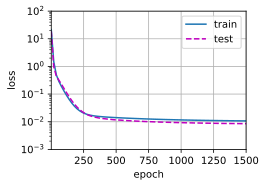

In [28]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [29]:
# 关于输入的线性函数，附加高斯噪声
# 问题的维数增加到d=200，并使用一个只包含20个样本的小训练集
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [30]:
# 初始化模型参数
def init_params():
    """ 初始化权重 """
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [31]:
# L2范数惩罚项
def l2_penalty(w):
    """ L2 范数惩罚项 """
    return torch.sum(w.pow(2)) / 2

In [32]:
# 定义训练代码的实现
def train(lambd):
    """ 训练 """
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])  
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.342970848083496


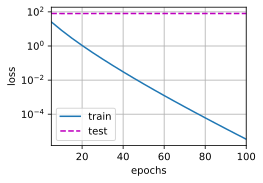

In [33]:
train(lambd=0)

w的L2范数是： 0.3512788414955139


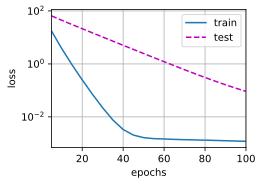

In [34]:
train(lambd=3)

In [35]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction="none")
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params": net[0].weight, "weight_decay": wd},
        {"params": net[0].bias}],
        lr=lr, 
    )
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())           

w的L2范数： 13.426837921142578


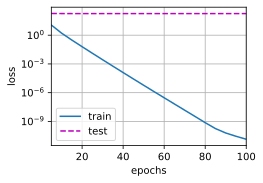

In [36]:
train_concise(0)

w的L2范数： 0.3764375150203705


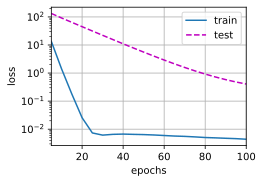

In [37]:
train_concise(3)